In [79]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim

In [80]:
accelerator = 'cuda' if torch.cuda.is_available() else 'cpu'

1. Create a straight line dataset

In [81]:
weight = 0.3
bias = 0.9
X = torch.arange(0, 1, 0.01).unsqueeze(dim=1)
y = weight * X + bias
split_var = int(0.8 * len(X))
X_train, X_test = X[:split_var], X[split_var:]
y_train, y_test = y[:split_var], y[split_var:]
print(f"Number of X samples: {len(X)}")
print(f"Number of y samples: {len(y)}")
print(f"First 10 X & y samples:\nX: {X[:10]}\ny: {y[:10]}")

Number of X samples: 100
Number of y samples: 100
First 10 X & y samples:
X: tensor([[0.0000],
        [0.0100],
        [0.0200],
        [0.0300],
        [0.0400],
        [0.0500],
        [0.0600],
        [0.0700],
        [0.0800],
        [0.0900]])
y: tensor([[0.9000],
        [0.9030],
        [0.9060],
        [0.9090],
        [0.9120],
        [0.9150],
        [0.9180],
        [0.9210],
        [0.9240],
        [0.9270]])


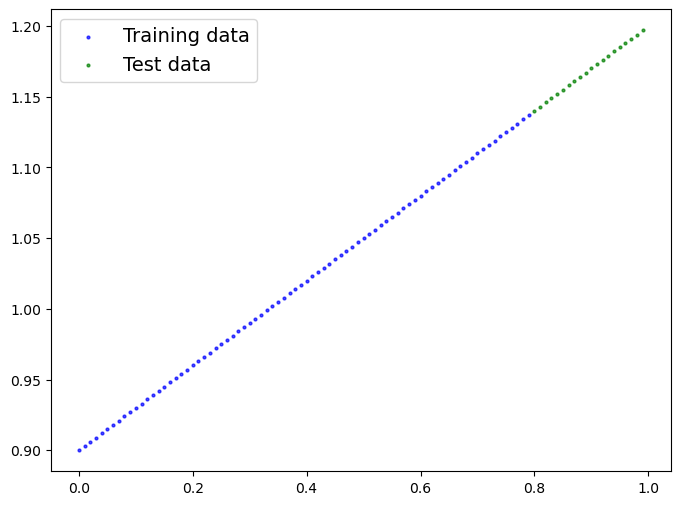

In [82]:
# Plot the training and testing data 
def plot_predictions(train_data = X_train,
                 train_labels = y_train,
                 test_data = X_test,
                 test_labels = y_test,
                 predictions = None):
  plt.figure(figsize = (8, 6))
  plt.scatter(train_data,train_labels,c = 'b',s = 4,label = "Training data", alpha=0.7)
  plt.scatter(test_data,test_labels,c = 'g',s = 4,label = "Test data", alpha=0.7)

  if predictions is not None:
    plt.scatter(test_data,predictions,c = 'r',s = 4,label = "Predictions")
  plt.legend(prop = {"size" : 14})
plot_predictions()

2. Build a PyTorch model by subclassing nn.Module

In [87]:
class linear_reg_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features = 1, out_features = 1)

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)
    
torch.manual_seed(42)
model_1 = linear_reg_model()
model_1, model_1.state_dict()

(linear_reg_model(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [88]:
next(model_1.parameters()).device

device(type='cpu')

In [89]:
# Instantiate the model and put it to the target device
model_1.to(device=accelerator)
list(model_1.parameters())

[Parameter containing:
 tensor([[0.7645]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.8300], device='cuda:0', requires_grad=True)]

3. Create a loss function and optimizer using nn.L1Loss() and torch.optim.SGD(params, lr)

In [90]:
loss_fn = nn.L1Loss()
optimizer = optim.SGD(params= model_1.parameters(), lr=0.01)

In [91]:
# move data to device
torch.manual_seed(42)
X_train = X_train.to(accelerator)
X_test = X_test.to(accelerator)
y_train = y_train.to(accelerator)
y_test = X_test.to(accelerator)

epochs = 300
for epoch in range(epochs):
    model_1.train()
    ### --- Training --- 
    # 1. forward
    y_preds = model_1(X_train)

    # 2. calculate loss
    loss = loss_fn(y_preds, y_train)

    # 3. zero grad optimizer
    optimizer.zero_grad()

    # 4. backward pass of loss
    loss.backward()

    # 5. optimizer step to update parameters
    optimizer.step()

    ### testing
    if epoch % 20 == 0:
        model_1.eval()
        with torch.inference_mode():
            # 1. forward
            test_preds = model_1(X_test)

            # 2. calculate loss
            test_loss = loss_fn(test_preds, y_test)

            # print results
            print(f"Epoch : {epoch} | Train loss : {loss:.3f} | Test loss : {test_loss:.3f}")


     

Epoch : 0 | Train loss : 0.128 | Test loss : 0.610
Epoch : 20 | Train loss : 0.082 | Test loss : 0.492
Epoch : 40 | Train loss : 0.072 | Test loss : 0.448
Epoch : 60 | Train loss : 0.065 | Test loss : 0.427
Epoch : 80 | Train loss : 0.058 | Test loss : 0.410
Epoch : 100 | Train loss : 0.051 | Test loss : 0.394
Epoch : 120 | Train loss : 0.045 | Test loss : 0.378
Epoch : 140 | Train loss : 0.038 | Test loss : 0.362
Epoch : 160 | Train loss : 0.031 | Test loss : 0.346
Epoch : 180 | Train loss : 0.024 | Test loss : 0.329
Epoch : 200 | Train loss : 0.017 | Test loss : 0.313
Epoch : 220 | Train loss : 0.010 | Test loss : 0.297
Epoch : 240 | Train loss : 0.003 | Test loss : 0.281
Epoch : 260 | Train loss : 0.008 | Test loss : 0.281
Epoch : 280 | Train loss : 0.008 | Test loss : 0.281


4. Make predictions with the trained model on the test data

In [ ]:
# make predictions with the model
model_1.eval()
with torch.inference_mode():
    test_preds = model_1(X_test)
test_preds

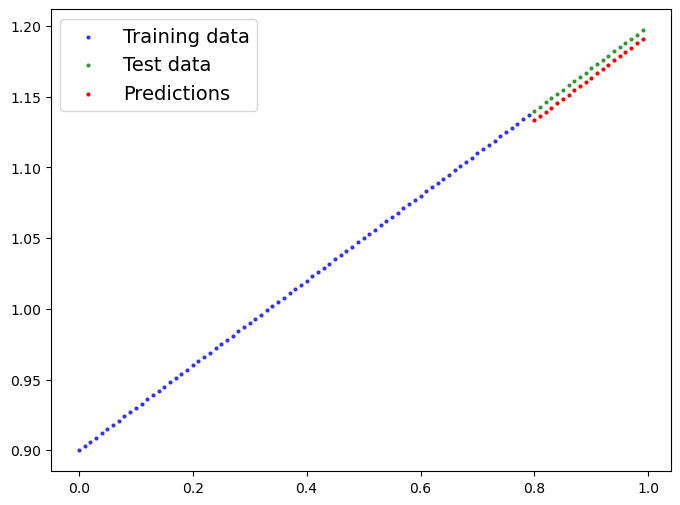

In [93]:
plot_predictions(predictions= test_preds.cpu())

5. save trained model's state_dict() to file.

In [94]:
from pathlib import Path

# 1. create path dir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
# 2. create model save path
MODEL_NAME = "01_linear_reg"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
# 3. save the model state dict
print(f"saving model to {MODEL_PATH}")
torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)

saving model to models


In [97]:
# load the saved model 
# 1. create model class instance
loaded_model1 = linear_reg_model()

# load state_dict using the instance
loaded_model1.load_state_dict(torch.load(MODEL_SAVE_PATH, weights_only=True))
loaded_model1.to(accelerator)

linear_reg_model(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [100]:
# make predictions using the loaded model
loaded_model1.eval()
with torch.inference_mode():
    load_preds = loaded_model1(X_test)
load_preds == test_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')

In [99]:
loaded_model1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.3028]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.8910], device='cuda:0'))])